In [1]:
!pip install transformers
!pip install peft
!pip install accelerate
!pip install torchvision
!pip install datasets
!pip install pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [5]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViltProcessor, ViltForQuestionAnswering, ViltConfig
from peft import get_peft_model, LoraConfig, TaskType
from PIL import Image
from tqdm import tqdm
import pandas as pd

# ============================
# 1. Load JSON and Preprocess
# ============================

root = "/content/drive/Othercomputers/MyMacBookPro/VR_PROJECT_2"
csv_path_train = os.path.join(root, "vqa_train_cleaned.csv")
csv_path_test = os.path.join(root, "vqa_test_cleaned.csv")  # Define the test path
image_base_path = os.path.join(root, "images")

df = pd.read_csv(csv_path_train, on_bad_lines='skip')
raw_data = df.to_json(orient='records', lines=False)

raw_data = json.loads(raw_data)

# Get unique answers and define label mappings
unique_answers = sorted({d["generated_answer"] for d in raw_data})
label2id = {label: i for i, label in enumerate(unique_answers)}
id2label = {i: label for label, i in label2id.items()}

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# ============================
# 2. Custom Dataset
# ============================

from torchvision import transforms

class CustomVQADataset(Dataset):
    def __init__(self, data, processor, label2id):
        self.data = data
        self.processor = processor
        self.label2id = label2id
        self.resize = transforms.Resize((384, 384))  # ViLT expects 384x384

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        row = self.data[idx]
        image_filename = row["path"]
        image_path = os.path.join(image_base_path, image_filename)
        image = Image.open(image_path).convert("RGB")
        image = self.resize(image)  # Resize image to fixed size
        question = item["generated_question"]
        answer = item["generated_answer"]

        encoding = self.processor(
            images=image,
            text=question,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}

        label_id = self.label2id[answer]
        encoding["labels"] = torch.tensor(label_id).long()  # ✅ use index not one-hot

        return encoding

from transformers import ViltForQuestionAnswering
import torch.nn as nn

class ViltForSingleLabelClassification(ViltForQuestionAnswering):
    def forward(self, *args, **kwargs):
        labels = kwargs.pop("labels", None)
        output = super().forward(*args, **kwargs)
        if labels is not None:
            logits = output.logits
            loss = nn.CrossEntropyLoss()(logits, labels)
            return type(output)(loss=loss, **{k: v for k, v in output.items() if k != "loss"})
        return output



# ============================
# 3. Model + LoRA
# ============================

config = ViltConfig.from_pretrained(
    "dandelin/vilt-b32-finetuned-vqa",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

base_model = base_model = ViltForSingleLabelClassification.from_pretrained(
    "dandelin/vilt-b32-finetuned-vqa",
    config=config,
    ignore_mismatched_sizes=True
)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(base_model, lora_config)

# ============================
# 4. Training
# ============================

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

dataset = CustomVQADataset(raw_data, processor, label2id)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(7):
    total_loss = 0
    for batch in tqdm(dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/136k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/470M [00:00<?, ?B/s]

Some weights of ViltForSingleLabelClassification were not initialized from the model checkpoint at dandelin/vilt-b32-finetuned-vqa and are newly initialized because the shapes did not match:
- classifier.3.weight: found shape torch.Size([3129, 1536]) in the checkpoint and torch.Size([526, 1536]) in the model instantiated
- classifier.3.bias: found shape torch.Size([3129]) in the checkpoint and torch.Size([526]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

100%|██████████| 835/835 [2:42:54<00:00, 11.71s/it]


Epoch 1 Loss: 2443.3667


100%|██████████| 835/835 [08:12<00:00,  1.70it/s]


Epoch 2 Loss: 1326.4214


100%|██████████| 835/835 [08:23<00:00,  1.66it/s]


Epoch 3 Loss: 1105.3257


100%|██████████| 835/835 [08:19<00:00,  1.67it/s]


Epoch 4 Loss: 972.6462


100%|██████████| 835/835 [08:15<00:00,  1.68it/s]


Epoch 5 Loss: 874.1809


100%|██████████| 835/835 [08:15<00:00,  1.69it/s]


Epoch 6 Loss: 795.3788


100%|██████████| 835/835 [08:18<00:00,  1.67it/s]

Epoch 7 Loss: 727.3258


In [6]:
save_directory = os.path.join(root, "vilt-finetuned-vqa")

# Create directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Save the model, processor, and config
model.save_pretrained(save_directory)
processor.save_pretrained(save_directory)
model.config.save_pretrained(save_directory)

print(f"Model and processor saved to {save_directory}")

Model and processor saved to /content/drive/Othercomputers/MyMacBookPro/VR_PROJECT_2/vilt-finetuned-vqa


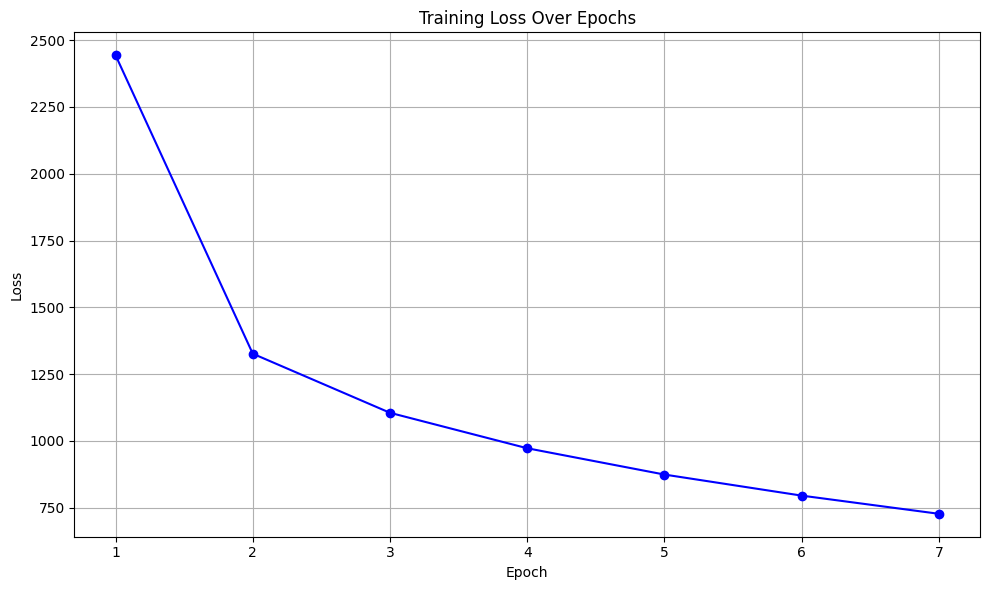

In [7]:
import matplotlib.pyplot as plt

# Loss values from each epoch
epochs = [1, 2, 3, 4, 5, 6, 7]
losses = [2443.3667, 1326.4214, 1105.3257, 972.6462, 874.1809, 795.3788, 727.3258]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='blue')

# Add labels and title
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()

# Show the plot
plt.show()
